# ⚛️ H₂ Excited States via SSVQE (Subspace-Search VQE)

This notebook computes the **ground state (E₀)** and the **first excited state (E₁)**
of the hydrogen molecule **H₂** using a **Subspace-Search VQE (SSVQE)**-style
cost function with your packaged VQE building blocks.

We use:

- Molecular + Hamiltonian logic from `vqe.hamiltonian`
- Ansatz and parameter initialisation from `vqe.ansatz`
- QNode construction and adjoint overlap tools from `vqe.engine`
- Multi-state convergence plotting from `vqe.visualize`

---

## 🎯 SSVQE Idea (Two-State Version)

We prepare two parameterised states:

\[
  |\psi_0(\theta_0)\rangle, \qquad |\psi_1(\theta_1)\rangle
\]

and minimise the cost

\[
  C(\theta_0, \theta_1)
  = E_0 + E_1 + \lambda\,|\langle \psi_0 | \psi_1 \rangle|^2
\]

where:

- \( E_i = \langle \psi_i | H | \psi_i \rangle \)
- The penalty term encourages **orthogonality** between the two states.

---

## Notebook Structure

1. **H₂ molecular setup & Hamiltonian** using `vqe.hamiltonian.build_hamiltonian`.
2. **SSVQE cost construction** using:
   - `vqe.ansatz.get_ansatz("UCCSD")`
   - `vqe.ansatz.init_params(...)`
   - `vqe.engine.make_energy_qnode(...)`
   - `vqe.engine.make_overlap00_fn(...)`
3. **Optimisation loop** with `vqe.optimizer.get_optimizer("Adam")`.
4. **Convergence visualisation** using `vqe.visualize.plot_ssvqe_convergence_multi`.
5. **State analysis**: amplitudes of \( |\psi_0\rangle \) and \( |\psi_1\rangle \).

This notebook is deliberately **H₂-focused** for speed and clarity, and uses only
your **packaged** VQE components.

## 1️⃣ Imports & Setup

In [1]:
import os
import sys

import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt

# Allow import of the package when running from notebooks/
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from vqe.hamiltonian import build_hamiltonian
from vqe.ansatz import get_ansatz, init_params
from vqe.engine import (
    make_device,
    make_energy_qnode,
    make_state_qnode,
    make_overlap00_fn,
)
from vqe.optimizer import get_optimizer
from vqe.visualize import plot_ssvqe_convergence_multi

# Reproducibility
np.random.seed(0)

## 2️⃣ H₂ Molecular Hamiltonian (Package-Based)

We use your **packaged Hamiltonian builder** to obtain:

- The qubit Hamiltonian \( H \)
- Number of qubits
- Underlying atomic symbols and coordinates

In [2]:
# Build H₂ Hamiltonian from the package
H, num_qubits, symbols, coordinates, basis = build_hamiltonian("H2")

print("Molecule:", "H2")
print("Basis:   ", basis)
print("Qubits:  ", num_qubits)
print("Symbols: ", symbols)
print("Coords (Å):")
print(coordinates)

Molecule: H2
Basis:    STO-3G
Qubits:   4
Symbols:  ['H', 'H']
Coords (Å):
[[0.     0.     0.    ]
 [0.     0.     0.7414]]


For reference, we can also compute the **Hartree–Fock energy** for H₂
using PennyLane's quantum chemistry tools.

In [3]:
electrons = 2  # H₂ has 2 electrons

hf_state = qchem.hf_state(electrons, num_qubits)

dev_hf = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev_hf)
def hf_energy_circuit():
    qml.BasisState(hf_state, wires=range(num_qubits))
    return qml.expval(H)

E_HF = float(hf_energy_circuit())
print(f"Hartree–Fock energy for H₂: {E_HF:.8f} Ha")

Hartree–Fock energy for H₂: -1.11668439 Ha


## 3️⃣ Building SSVQE Components from the Package

We now construct the ingredients for a **two-state SSVQE**:

- A **UCCSD ansatz**: `get_ansatz("UCCSD")`
- Initial parameter vectors `θ₀` and `θ₁` via `init_params(...)`
- An **energy QNode** via `make_energy_qnode(...)`
- An **overlap estimator** \( |\langle \psi_0 | \psi_1 \rangle|^2 \) via
  `make_overlap00_fn(...)`.

These are all provided by your package — the notebook simply wires them together.

In [4]:
# Noiseless device for SSVQE
dev = make_device(num_qubits, noisy=False)

# Package ansatz: UCCSD
ansatz_name = "UCCSD"
ansatz_fn = get_ansatz(ansatz_name)

# Energy QNode <H>
energy_qnode = make_energy_qnode(
    H,
    dev,
    ansatz_fn,
    num_qubits,
    noisy=False,
    depolarizing_prob=0.0,
    amplitude_damping_prob=0.0,
    symbols=symbols,
    coordinates=coordinates,
    basis=basis,
)

# Overlap estimator using the "adjoint trick":
# overlap00(p0, p1) ≈ |⟨ψ0|ψ1⟩|²
overlap00 = make_overlap00_fn(
    dev,
    ansatz_fn,
    num_qubits,
    noisy=False,
    depolarizing_prob=0.0,
    amplitude_damping_prob=0.0,
    symbols=symbols,
    coordinates=coordinates,
    basis=basis,
)

### Initial Parameters for Two States

We initialise two independent sets of UCCSD parameters:

- \( \theta_0 \) for the ground-state branch
- \( \theta_1 \) for the excited-state branch

using `init_params(...)` with different random seeds.

In [5]:
# Build initial parameters for |ψ0> and |ψ1>
theta0 = init_params(
    ansatz_name,
    num_qubits,
    symbols=symbols,
    coordinates=coordinates,
    basis=basis,
    seed=0,
)

theta1 = init_params(
    ansatz_name,
    num_qubits,
    symbols=symbols,
    coordinates=coordinates,
    basis=basis,
    seed=1,
)

print("θ₀ shape:", theta0.shape)
print("θ₁ shape:", theta1.shape)

# Flatten and concatenate to a single optimisation vector
theta = np.concatenate([theta0, theta1])
n_params_single = len(theta0)

θ₀ shape: (3,)
θ₁ shape: (3,)


## 4️⃣ Two-State SSVQE Cost Function

We now define the **SSVQE cost**

\[
  C(\theta_0, \theta_1)
  = E_0 + E_1 + \lambda\,|\langle \psi_0 | \psi_1 \rangle|^2
\]

where:

- \(E_0 = \langle \psi_0 | H | \psi_0 \rangle\)
- \(E_1 = \langle \psi_1 | H | \psi_1 \rangle\)
- The penalty term enforces approximate orthogonality.

We use `vqe.optimizer.get_optimizer("Adam")` as in your other notebooks.

In [6]:
penalty_weight = 10.0  # λ in the SSVQE cost

def split_theta(theta_flat):
    """Split a flat parameter vector into (θ₀, θ₁)."""
    t0 = theta_flat[:n_params_single]
    t1 = theta_flat[n_params_single:]
    return t0, t1

def ssvqe_cost(theta_flat):
    """Two-state SSVQE cost C = E0 + E1 + λ |⟨ψ0|ψ1⟩|²."""
    t0, t1 = split_theta(theta_flat)
    E0 = energy_qnode(t0)
    E1 = energy_qnode(t1)
    # overlap00 returns approximately |⟨ψ0|ψ1⟩|²
    penalty = penalty_weight * overlap00(t0, t1)
    return E0 + E1 + penalty

# Optimizer from the package
stepsize = 0.2
opt = get_optimizer("Adam", stepsize=stepsize)

## 5️⃣ Running the SSVQE Optimisation

We now:

- Optimise the joint parameter vector \( (\theta_0, \theta_1) \)
- Track the individual energies \(E_0, E_1\) at each iteration
- Observe the convergence of both states

The optimisation is done *entirely* using your packaged components.

In [7]:
n_steps = 80

theta_opt = np.array(theta, requires_grad=True)

E0_list = []
E1_list = []

for step in range(n_steps):
    theta_opt, _ = opt.step_and_cost(ssvqe_cost, theta_opt)
    t0, t1 = split_theta(theta_opt)
    E0 = float(energy_qnode(t0))
    E1 = float(energy_qnode(t1))
    E0_list.append(E0)
    E1_list.append(E1)
    print(f"Step {step+1:02d}/{n_steps} — E₀ = {E0:.8f} Ha, E₁ = {E1:.8f} Ha")

Step 01/80 — E₀ = -1.13699403 Ha, E₁ = -1.13699403 Ha
Step 02/80 — E₀ = -1.13100745 Ha, E₁ = -1.13100745 Ha
Step 03/80 — E₀ = -1.12261599 Ha, E₁ = -1.12261599 Ha
Step 04/80 — E₀ = -1.13009993 Ha, E₁ = -1.13009993 Ha
Step 05/80 — E₀ = -1.13304853 Ha, E₁ = -1.13304833 Ha
Step 06/80 — E₀ = -1.13441483 Ha, E₁ = -1.13440913 Ha
Step 07/80 — E₀ = -1.13461790 Ha, E₁ = -1.13458410 Ha
Step 08/80 — E₀ = -1.13176133 Ha, E₁ = -1.13196620 Ha
Step 09/80 — E₀ = -1.12514425 Ha, E₁ = -1.12401536 Ha
Step 10/80 — E₀ = -1.10827100 Ha, E₁ = -1.10607302 Ha
Step 11/80 — E₀ = -1.07282062 Ha, E₁ = -1.06647038 Ha
Step 12/80 — E₀ = -1.01664824 Ha, E₁ = -0.98899084 Ha
Step 13/80 — E₀ = -0.94257428 Ha, E₁ = -0.85952911 Ha
Step 14/80 — E₀ = -0.85857175 Ha, E₁ = -0.67467156 Ha
Step 15/80 — E₀ = -0.77838151 Ha, E₁ = -0.45099723 Ha
Step 16/80 — E₀ = -0.71450247 Ha, E₁ = -0.23709321 Ha
Step 17/80 — E₀ = -0.66811368 Ha, E₁ = -0.08779971 Ha
Step 18/80 — E₀ = -0.63061581 Ha, E₁ = -0.00709059 Ha
Step 19/80 — E₀ = -0.5920824

## 6️⃣ Visualising Multi-State Convergence (Package Plotting)

To keep style consistent with your other notebooks, we use
`vqe.visualize.plot_ssvqe_convergence_multi(...)` to visualise the
convergence of both states.

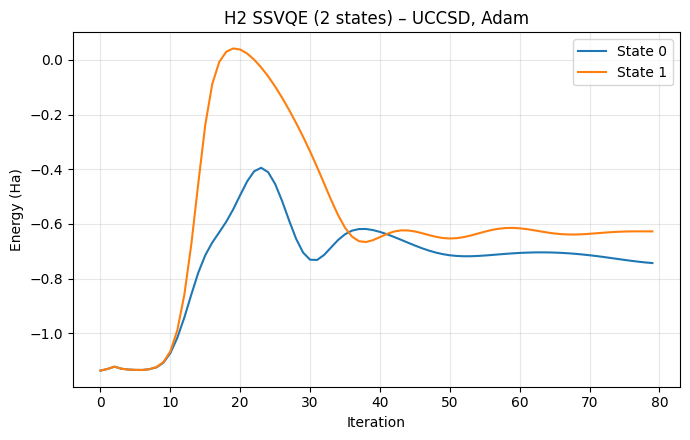

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/H2_ssvqe_convergence_states2_ansUCCSD_optAdam.png


In [8]:
energies_per_state = {0: E0_list, 1: E1_list}

plot_ssvqe_convergence_multi(
    energies_per_state,
    molecule="H2",
    ansatz=ansatz_name,
    optimizer="Adam",
    show=True,
    save=True,
)

## 7️⃣ Final Energies & Excitation Gap

We now report:

- Final ground-state energy \(E_0\)
- First excited-state energy \(E_1\)
- Excitation gap \( \Delta E = E_1 - E_0 \)
- Comparison to the Hartree–Fock reference

In [9]:
final_E0 = E0_list[-1]
final_E1 = E1_list[-1]
delta_E = final_E1 - final_E0

print(f"H₂ — SSVQE Results (UCCSD, Adam)")
print(f"E_HF (reference) = {E_HF:.8f} Ha")
print(f"E₀ (ground)      = {final_E0:.8f} Ha")
print(f"E₁ (excited)     = {final_E1:.8f} Ha")
print(f"ΔE = E₁ - E₀      = {delta_E:.88f} Ha")

H₂ — SSVQE Results (UCCSD, Adam)
E_HF (reference) = -1.11668439 Ha
E₀ (ground)      = -0.74336802 Ha
E₁ (excited)     = -0.62753618 Ha
ΔE = E₁ - E₀      = 0.1158318385373922065895158084458671510219573974609375000000000000000000000000000000000000 Ha


## 8️⃣ Statevector Analysis

Finally, we reconstruct the two states \( |\psi_0\rangle \) and \( |\psi_1\rangle \)
using `vqe.engine.make_state_qnode(...)` and compare their **basis-state amplitudes**.

Only amplitudes above a small threshold are displayed for clarity.

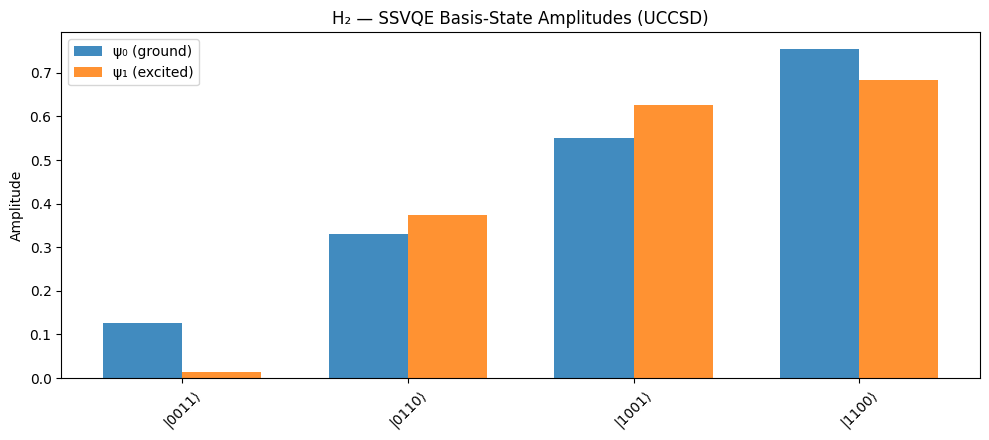

In [10]:
# State QNode using the same ansatz + device
state_qnode = make_state_qnode(
    dev,
    ansatz_fn,
    num_qubits,
    noisy=False,
    depolarizing_prob=0.0,
    amplitude_damping_prob=0.0,
    symbols=symbols,
    coordinates=coordinates,
    basis=basis,
)

t0_opt, t1_opt = split_theta(theta_opt)

psi0 = state_qnode(t0_opt)
psi1 = state_qnode(t1_opt)

# Identify significant amplitudes
threshold = 1e-2
indices = np.unique(
    np.where(
        (np.abs(psi0) > threshold) | (np.abs(psi1) > threshold)
    )[0]
)

labels = [f"|{i:0{num_qubits}b}⟩" for i in indices]
amp0 = np.abs([psi0[i] for i in indices])
amp1 = np.abs([psi1[i] for i in indices])

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 4.5))
plt.bar(x - width/2, amp0, width, alpha=0.85, label="ψ₀ (ground)")
plt.bar(x + width/2, amp1, width, alpha=0.85, label="ψ₁ (excited)")
plt.xticks(x, labels, rotation=45)
plt.ylabel("Amplitude")
plt.title("H₂ — SSVQE Basis-State Amplitudes (UCCSD)")
plt.legend()
plt.tight_layout()
plt.show()

## ✅ Summary

In this notebook, you:

- Built the **H₂ qubit Hamiltonian** using `vqe.hamiltonian.build_hamiltonian`.
- Used `vqe.ansatz.get_ansatz("UCCSD")` and `init_params(...)` to define a
  chemically motivated ansatz.
- Constructed energy and overlap QNodes via `vqe.engine.make_energy_qnode`
  and `make_overlap00_fn`.
- Implemented a **two-state SSVQE cost** and optimised it using
  `vqe.optimizer.get_optimizer("Adam")`.
- Visualised multi-state convergence with
  `vqe.visualize.plot_ssvqe_convergence_multi`.
- Analysed the resulting states’ **basis amplitudes**.

This gives you a fully **H₂-based, package-aligned** SSVQE notebook that fits
cleanly into your educational H₂ series.